In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict as dd
import os

In [ ]:
df1=pd.read_csv("healthy_data.csv")
df2=pd.read_csv("broken_data.csv")
df=pd.concat([df1,df2], axis =0)

In [ ]:
df

,a1,a2,a3,a4,load,failure
0,4.636710,0.516978,-3.205940,1.822410,0.0,0.0
1,1.992800,4.184660,-2.740610,2.804360,0.0,0.0
2,-3.764110,0.997335,-1.303090,1.836680,0.0,0.0
3,-4.558710,6.104330,-1.720690,1.723110,0.0,0.0
4,0.575382,0.170980,-0.497967,-1.328950,0.0,0.0
...,...,...,...,...,...,...
505868,3.737210,0.672242,-0.333635,-3.744020,50.0,1.0
505869,-1.585760,5.304570,-5.597700,-0.950527,50.0,1.0
505870,-6.014400,4.844960,-4.748150,2.255030,50.0,1.0
505871,-5.239620,3.247020,-0.661147,2.492990,50.0,1.0


In [ ]:
sensor_readings = df.melt(
    id_vars=['failure','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

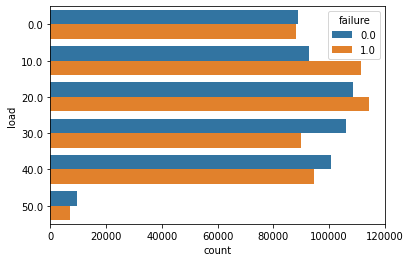

In [ ]:
sns.countplot(
    data=sensor_readings[sensor_readings.sensor=='a1'],
    y='load',
    hue='failure',
)

In [ ]:
# helper function to filter the dataset
def rdg(df, failure=None, load=None, sensor=None):
    df_st = df[df.failure==failure] if failure is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

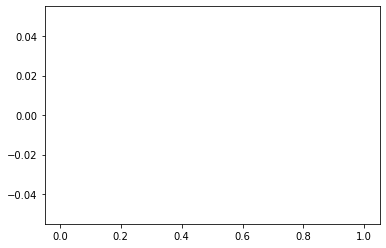

In [ ]:
plt.hist(rdg(sensor_readings, 1, 90, 'a2').reading.values[:1000], color='r', alpha=0.3) # broken tooth
plt.hist(rdg(sensor_readings, 0, 90, 'a2').reading.values[:1000], color='g', alpha=0.3) # healthy
plt.show()

In [ ]:
data = []
labels = []
i=0
j=0
for (state,load,sensor),g in sensor_readings.groupby(['failure','load','sensor']):
    vals = g.reading.values
    if(j==0):
      print(vals)
      print(len(vals))
      j+=1
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    if(i==0):
      print(len(splits))
      i+=1
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state==1))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

[  4.63671   1.9928   -3.76411 ...   6.53028  -8.61446 -13.7773 ]
88832
89


((4024, 9), (4024,))

In [ ]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 4024
Fault class: 2012 (50.0%)


In [ ]:
sensor_readings

,failure,load,sensor,reading
0,0.0,0.0,a1,4.636710
1,0.0,0.0,a1,1.992800
2,0.0,0.0,a1,-3.764110
3,0.0,0.0,a1,-4.558710
4,0.0,0.0,a1,0.575382
...,...,...,...,...
4049807,1.0,50.0,a4,-3.744020
4049808,1.0,50.0,a4,-0.950527
4049809,1.0,50.0,a4,2.255030
4049810,1.0,50.0,a4,2.492990


In [ ]:
df_data

,sensor_a1,sensor_a2,sensor_a3,load,mean,std,kurt,skew,moment
0,1,0,0,0.0,-0.021091,5.547919,2.626183,0.025210,0.0
1,1,0,0,0.0,-0.012301,6.201618,3.640234,-0.047139,0.0
2,1,0,0,0.0,-0.071201,5.110114,3.554958,-0.154070,0.0
3,1,0,0,0.0,-0.031611,5.793023,1.543246,-0.043227,0.0
4,1,0,0,0.0,-0.039073,6.103405,2.166403,0.058691,0.0
...,...,...,...,...,...,...,...,...,...
4019,0,0,0,50.0,0.126714,4.249504,1.368292,-0.034968,0.0
4020,0,0,0,50.0,0.200045,5.425529,2.286778,0.028748,0.0
4021,0,0,0,50.0,-0.591703,4.486497,0.846542,-0.009614,0.0
4022,0,0,0,50.0,0.196290,4.724178,1.561897,-0.220734,0.0


In [ ]:
cols_to_scale = ['load','mean','std','kurt','skew','moment']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_data[cols_to_scale] = scaler.fit_transform(df_data[cols_to_scale])

In [ ]:
df_data

,sensor_a1,sensor_a2,sensor_a3,load,mean,std,kurt,skew,moment
0,1,0,0,0.0,0.692549,0.430269,0.345707,0.527525,0.0
1,1,0,0,0.0,0.697601,0.524290,0.476545,0.488238,0.0
2,1,0,0,0.0,0.663755,0.367299,0.465542,0.430171,0.0
3,1,0,0,0.0,0.686504,0.465522,0.205982,0.490362,0.0
4,1,0,0,0.0,0.682216,0.510164,0.286384,0.545707,0.0
...,...,...,...,...,...,...,...,...,...
4019,0,0,0,1.0,0.777483,0.243518,0.183409,0.494847,0.0
4020,0,0,0,1.0,0.819622,0.412665,0.301916,0.529447,0.0
4021,0,0,0,1.0,0.364657,0.277605,0.116090,0.508615,0.0
4022,0,0,0,1.0,0.817464,0.311790,0.208388,0.393971,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_data, labels,
    train_size=0.8,
    random_state=42,
    # stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (3219, 9)
Test data: (805, 9)


In [ ]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(9,), activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist=model.fit(X_train, y_train, epochs=100)

Epoch 1/100
101/101 [==============================] - 3s 3ms/step - loss: 0.6778 - accuracy: 0.6356
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 0.5659 - accuracy: 0.6928
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4851 - accuracy: 0.7468
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4568 - accuracy: 0.7683
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.7835
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4330 - accuracy: 0.7872
Epoch 7/100
101/101 [==============================] - 0s 4ms/step - loss: 0.4200 - accuracy: 0.7996
Epoch 8/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.7931
Epoch 9/100
101/101 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.8124
Epoch 10/100
101/101 [==============================] - 0s 3ms/step - loss: 0.3935 - accura

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = model.predict(X_test, batch_size=128, verbose=1)
predicted=np.argmax(pred)

7/7 [==============================] - 0s 2ms/step


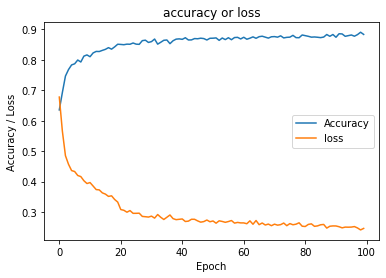

In [ ]:
#visualize training and testing data 
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['loss'])
plt.title("accuracy or loss")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()